# import libraries

In [2]:
import os
import skimage.io
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import zipfile
import json
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.transform import resize
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix ,ConfusionMatrixDisplay ,roc_curve, auc , accuracy_score , classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# helpful function

In [3]:
# display some images from the dataset

def draw_func(list_of_imgs, list_of_labels):
    # create figure
    fig = plt.figure(figsize=(10, 7))
    # setting values to rows and column variables
    rows, columns = 3, 3

    # Separate fake and real images based on labels
    fake_images = [img for img, label in zip(list_of_imgs, list_of_labels) if label == 'fake' or 'fake1' or 'fake2' or 'fake3' or 'fake4'or 'fake5'  ]
    real_images = [img for img, label in zip(list_of_imgs, list_of_labels) if label == 'real' or 'real1'or 'real2'or 'real3'or 'real4'or 'real5']

    # Randomly select fake and real images with appropriate sample sizes
    fake_sample_size = min(5, len(fake_images))  # Adjust sample size if fewer than 5 fake images
    real_sample_size = min(4, len(real_images))  # Adjust sample size if fewer than 4 real images
    fake_sample = random.sample(fake_images, fake_sample_size)
    real_sample = random.sample(real_images, real_sample_size)

    # Combine the selected images and labels
    sample_images = fake_sample + real_sample
    sample_labels = ['fake'] * fake_sample_size + ['real'] * real_sample_size

    # Iterate over the selected images and labels
    for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
        # Adds a subplot at the i+1 position
        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)  # Set the title as the corresponding label

    plt.tight_layout()
    plt.show()

In [4]:
# Define a learning rate schedule
def lr_schedule(epoch):
    lr = 1e-4 * (0.95 ** epoch)  # Reduce the learning rate by 5% every epoch
    return lr

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [5]:
# Plot learning curve
def plot_learning_curve(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

In [6]:
# function for evaluate the modl on test data
threshold = 0.5
def evaluate_test(model):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test , y_test, verbose=0)
    y_test_pred = model.predict(x_test)
    threshold = 0.5
    y_test_pred_binary = (y_test_pred > threshold).astype(int)


    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    # Generate a classification report
    report = classification_report(y_test, y_test_pred_binary)

    # Print the classification report
    print("\n")
    print("Classification Report:")
    print(report)
    return test_loss, test_accuracy

In [7]:
# function for predict confusion matrix
def prediction_confmatrix(model):
    # Get the predicted labels for training, validation, and test sets
    y_train_pred = model.predict(x_train)
    y_val_pred  = model.predict(x_val)
    y_test_pred = model.predict(x_test)

    threshold = 0.5
    y_train_pred_binary = (y_train_pred > threshold).astype(int)
    y_val_pred_binary = (y_val_pred > threshold).astype(int)
    y_test_pred_binary = (y_test_pred > threshold).astype(int)


    # Compute the confusion matrix for training, validation, and test sets
    train_conf_matrix = confusion_matrix(y_train,y_train_pred_binary)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred_binary)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

        # Set up the plot with a blue color map
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)

    # Plot the confusion matrix for training set
    sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[0])
    axes[0].set(title='Confusion Matrix - Training Set')

    # Print the confusion matrix for training set
    print("Confusion Matrix - Training Set:")
    print(train_conf_matrix)

    # Plot the confusion matrix for validation set
    sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[1])
    axes[1].set(title='Confusion Matrix - Validation Set')

    # Print the confusion matrix for validation set
    print("Confusion Matrix - Validation Set:")
    print(val_conf_matrix)

    # Plot the confusion matrix for test set
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[2])
    axes[2].set(title='Confusion Matrix - Test Set')

    # Print the confusion matrix for test set
    print("Confusion Matrix - Test Set:")
    print(test_conf_matrix)

    plt.show()

    return y_train_pred_binary ,y_val_pred_binary, y_test_pred_binary ,train_conf_matrix,val_conf_matrix,test_conf_matrix

In [8]:
# Function to load images and resize them to (128, 128, 3)
def load_images(folder_path, limit=10000):
    images = []
    file_names = os.listdir(folder_path)

    # Ensure we don't exceed the limit
    for i, file_name in enumerate(file_names):
        if i >= limit:
            break
        file_path = os.path.join(folder_path, file_name)
        image = skimage.io.imread(file_path)
        image = resize(image, (128, 128, 3), anti_aliasing=True)
        images.append(image)

    return images

# load dataset

In [9]:
#define path and folders inside it
train_p ='E:\\New folder (6)\\New folder\\train'
test_p ='E:\\New folder (6)\\New folder\\test'
val_p = 'E:\\New folder (6)\\New folder\\valid'
folders = [f for f in os.listdir(train_p)]
print("folders=", folders)

folders= ['fake', 'real']


train data

In [10]:
#load the train data and put it in dataframe
train = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(train_p, folder))
    train_df = pd.DataFrame({'image': images ,'label': folder})
    train = pd.concat([train_df,train], ignore_index=False)
# Shuffle the data in the DataFrame
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,image,label
0,"[[[0.5089278929136994, 0.41481024585487597, 0....",real
1,"[[[0.8631214456175602, 0.8236478309005342, 0.7...",real
2,"[[[0.8859757940124132, 0.9447060043906358, 0.9...",fake
3,"[[[0.36608080306365126, 0.22508923376223577, 0...",fake
4,"[[[0.9843622914610901, 0.2031558205217102, 0.3...",real


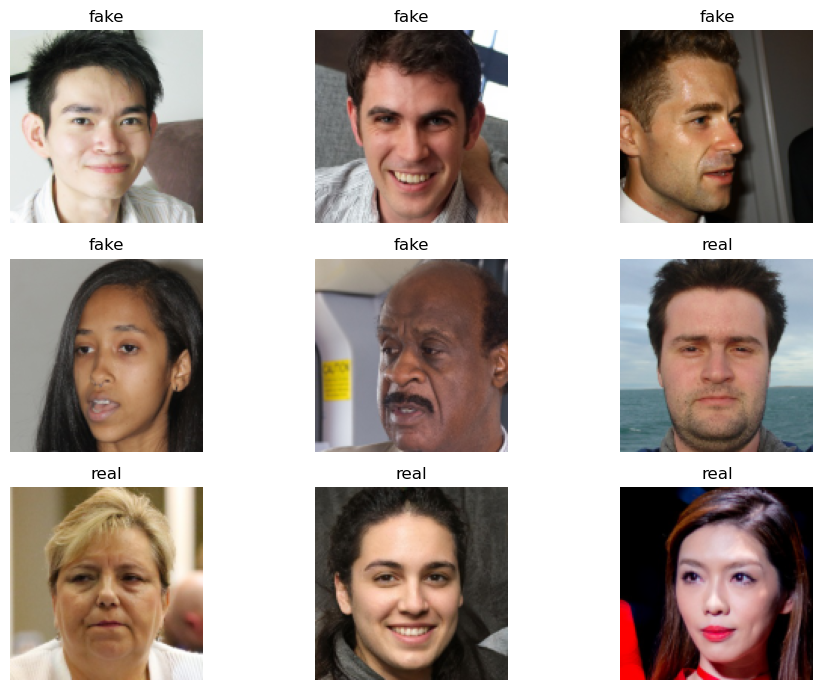

In [11]:
# show images sampels
draw_func(train['image'] ,train['label'])

test data

In [12]:
#load the test data and put it in dataframe
test = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(test_p, folder))
    test_df = pd.DataFrame({'image': images ,'label': folder})
    test = pd.concat([test_df,test], ignore_index=False)

# Shuffle the data in the DataFrame
test = test.sample(frac=1).reset_index(drop=True)
test


,image,label
0,"[[[0.33487511149177374, 0.3762615748657635, 0....",real
1,"[[[0.8148920283166549, 0.7232817931918549, 0.6...",fake
2,"[[[0.42760264736676046, 0.5047374670653183, 0....",real
3,"[[[0.1518548911770485, 0.11967886918201248, 0....",fake
4,"[[[0.07058846631097197, 0.07450980392156861, 0...",real
...,...,...
19995,"[[[0.47627367738979737, 0.4102036708633565, 0....",fake
19996,"[[[0.036227064060050475, 0.03230549543259949, ...",fake
19997,"[[[0.786275258203291, 0.7509811405562321, 0.68...",real
19998,"[[[0.15792635421328177, 0.08341594981772865, 0...",real


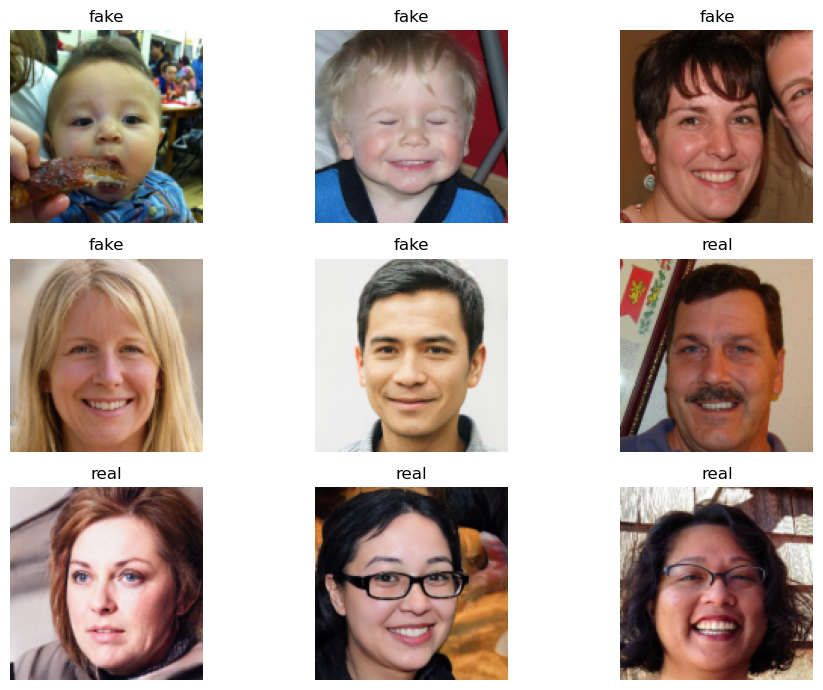

In [13]:
# show images sampels
draw_func(test['image'] ,test['label'])

validation data

In [14]:
#load the val data and put it in dataframe
val = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(val_p, folder))
    val_df = pd.DataFrame({'image': images ,'label': folder})
    val = pd.concat([val_df,val], ignore_index=False)

# Shuffle the data in the DataFrame
val = val.sample(frac=1).reset_index(drop=True)
val.head()

,image,label
0,"[[[0.22467501353148897, 0.3200420530594492, 0....",real
1,"[[[0.16393223819736508, 0.19530426983445776, 0...",fake
2,"[[[0.2341243257042244, 0.27726152512085944, 0....",fake
3,"[[[0.3390032768095891, 0.48272709885216514, 0....",fake
4,"[[[0.869073666193211, 0.9684424196588045, 0.99...",real


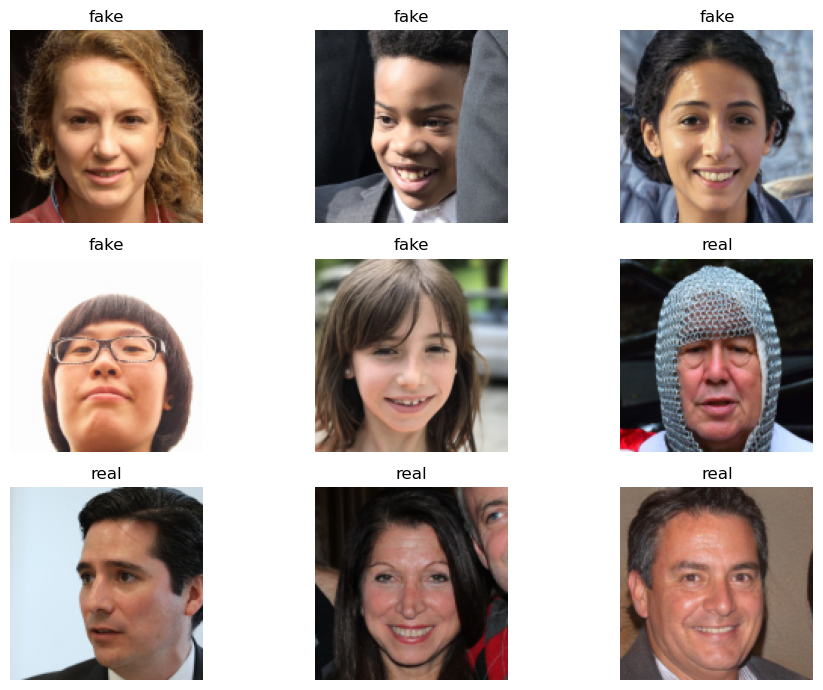

In [15]:
# show images sampels
draw_func(val['image'] ,val['label'])

# preprocess the data

In [16]:
#specify x for (train,val,test) then convert them to np.array to match the model
x_train = train['image']
x_val = val['image']
x_test = test['image']

x_train = np.stack(x_train.values)
x_val = np.stack(x_val.values)
x_test = np.stack(x_test.values)

In [17]:
x_train.shape , x_val.shape  , x_test.shape

((20000, 128, 128, 3), (20000, 128, 128, 3), (20000, 128, 128, 3))

In [18]:
#specify y for (train,val,test) then convert them to categorical to match the model
y_train = train['label']
y_val = val['label']
y_test = test['label']

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train= label_encoder.transform(y_train)

label_encoder.fit(y_val)
y_val= label_encoder.transform(y_val)

label_encoder.fit(y_test)
y_test= label_encoder.transform(y_test)

In [19]:
y_train.shape , y_val.shape  , y_test.shape

((20000,), (20000,), (20000,))

# models

In [20]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

**MobileNetV2**

In [21]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model without the top (classification) layers
base_model1 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,586,177
Trainable params: 2,552,065
Non-trainable params: 34,112
_________________________________________________________________


In [22]:
# Compile the model
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history1 = model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=16, callbacks=[lr_scheduler,early_stopping])

Epoch 1/20
1250/1250 [==============================] - 920s 702ms/step - loss: 0.3385 - accuracy: 0.8478 - val_loss: 0.4499 - val_accuracy: 0.8450 - lr: 1.0000e-04
Epoch 2/20
1250/1250 [==============================] - 575s 460ms/step - loss: 0.1504 - accuracy: 0.9427 - val_loss: 0.1586 - val_accuracy: 0.9445 - lr: 9.5000e-05
Epoch 3/20
1250/1250 [==============================] - 573s 459ms/step - loss: 0.0883 - accuracy: 0.9674 - val_loss: 0.1930 - val_accuracy: 0.9409 - lr: 9.0250e-05
Epoch 4/20
1250/1250 [==============================] - 569s 455ms/step - loss: 0.0596 - accuracy: 0.9788 - val_loss: 0.1941 - val_accuracy: 0.9388 - lr: 8.5737e-05
Epoch 5/20
1250/1250 [==============================] - 570s 456ms/step - loss: 0.0415 - accuracy: 0.9844 - val_loss: 0.4591 - val_accuracy: 0.8899 - lr: 8.1451e-05
Epoch 6/20
1250/1250 [==============================] - 571s 457ms/step - loss: 0.0313 - accuracy: 0.9891 - val_loss: 0.1403 - val_accuracy: 0.9581 - lr: 7.7378e-05
Epoch 7/20

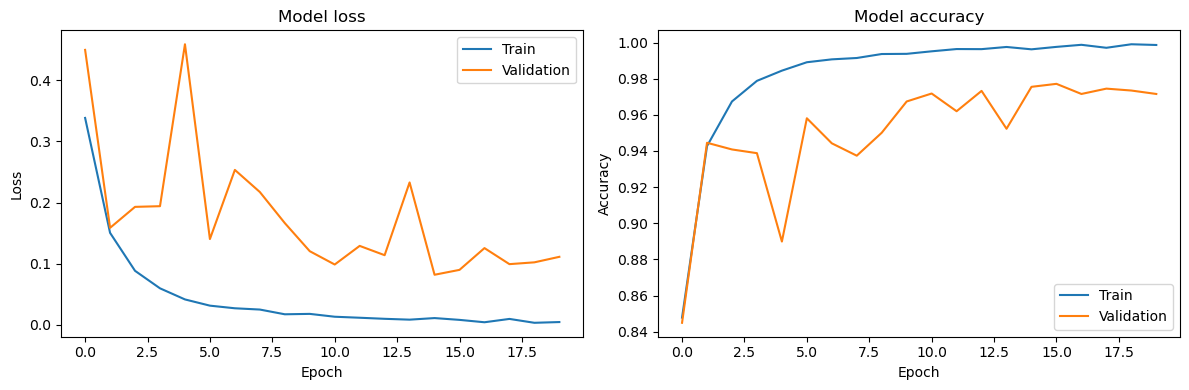

In [23]:
# Plot the learning curve
plot_learning_curve(history1)

In [24]:
# evaluate the model in test data
evaluation1=evaluate_test(model1)

625/625 [==============================] - 86s 132ms/step
Test Loss: 0.11995647102594376
Test Accuracy: 0.9714999794960022
Test Accuracy: 97.15%


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     10000
           1       0.96      0.99      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



625/625 [==============================] - 88s 141ms/step
Confusion Matrix - Training Set:
[[9968   32]
 [   1 9999]]
Confusion Matrix - Validation Set:
[[9530  470]
 [  99 9901]]
Confusion Matrix - Test Set:
[[9545  455]
 [ 115 9885]]


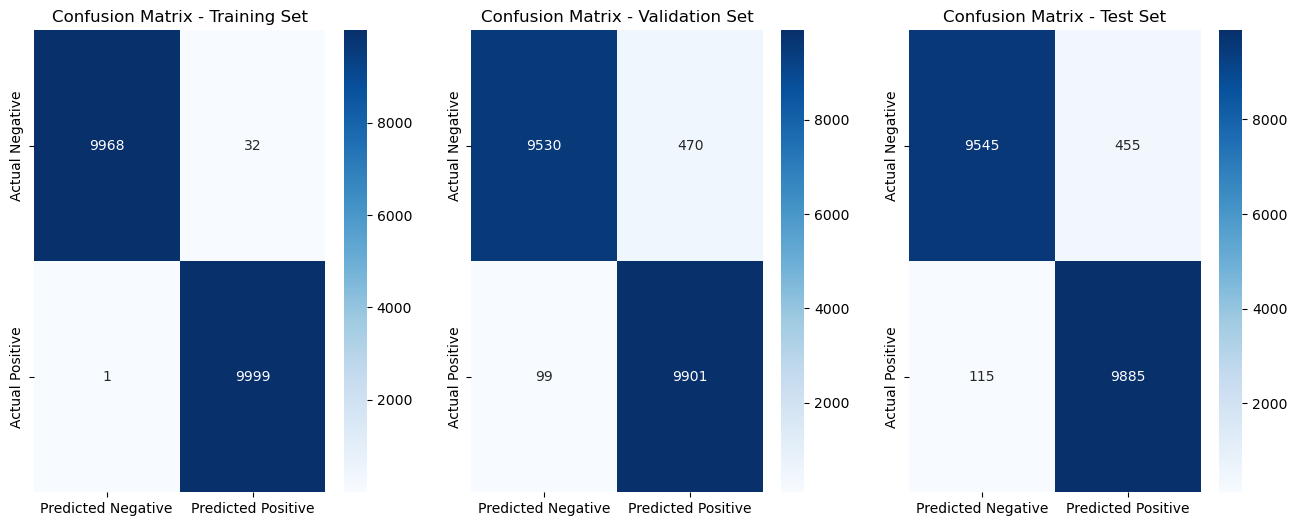

In [25]:
# predict values and confusion matrix
prediction1=prediction_confmatrix(model1)

In [26]:
# save whole model 
model1.save("model1MobileNetV2")
model1.save("model1MobileNetV2withlargescale.h5")
#save only weights
model1.save_weights('model1MobileNetweightswithlargescale.h5')

INFO:tensorflow:Assets written to: model1MobileNetV2\assets


INFO:tensorflow:Assets written to: model1MobileNetV2\assets


 **Hyperprameter section for** **MobileNetV2**

increase batch size 

In [27]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [28]:
# Load the MobileNetV2 model without the top (classification) layers
base_model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,586,177
Trainable params: 2,552,065
Non-trainable params: 34,112
_________________________________________________________________


In [29]:

# Compile the model
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, callbacks=[lr_scheduler,early_stopping])

Epoch 1/20
625/625 [==============================] - 531s 833ms/step - loss: 0.3441 - accuracy: 0.8454 - val_loss: 0.9803 - val_accuracy: 0.7397 - lr: 1.0000e-04
Epoch 2/20
625/625 [==============================] - 441s 706ms/step - loss: 0.1119 - accuracy: 0.9566 - val_loss: 0.3488 - val_accuracy: 0.8806 - lr: 9.5000e-05
Epoch 3/20
625/625 [==============================] - 439s 703ms/step - loss: 0.0556 - accuracy: 0.9796 - val_loss: 0.2505 - val_accuracy: 0.9239 - lr: 9.0250e-05
Epoch 4/20
625/625 [==============================] - 438s 701ms/step - loss: 0.0411 - accuracy: 0.9836 - val_loss: 0.3000 - val_accuracy: 0.9207 - lr: 8.5737e-05
Epoch 5/20
625/625 [==============================] - 438s 701ms/step - loss: 0.0330 - accuracy: 0.9887 - val_loss: 0.5283 - val_accuracy: 0.8939 - lr: 8.1451e-05
Epoch 6/20
625/625 [==============================] - 437s 700ms/step - loss: 0.0232 - accuracy: 0.9918 - val_loss: 0.2399 - val_accuracy: 0.9471 - lr: 7.7378e-05
Epoch 7/20
625/625 [==

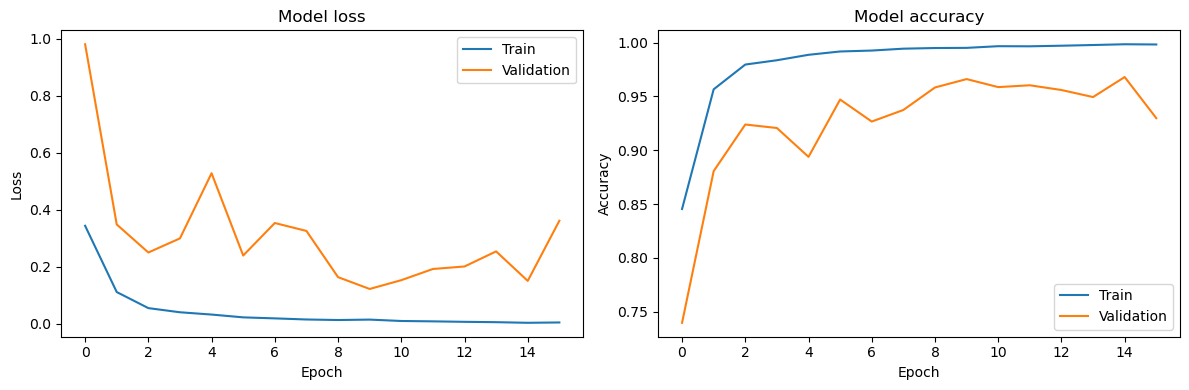

In [30]:
# Plot the learning curve
plot_learning_curve(history2)

In [31]:
# evaluate the model in test data
evaluation2=evaluate_test(model2)

625/625 [==============================] - 76s 119ms/step
Test Loss: 0.13130119442939758
Test Accuracy: 0.9639000296592712
Test Accuracy: 96.39%


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     10000
           1       0.97      0.96      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



625/625 [==============================] - 87s 131ms/step
Confusion Matrix - Training Set:
[[9996    4]
 [  12 9988]]
Confusion Matrix - Validation Set:
[[9694  306]
 [ 372 9628]]
Confusion Matrix - Test Set:
[[9714  286]
 [ 436 9564]]


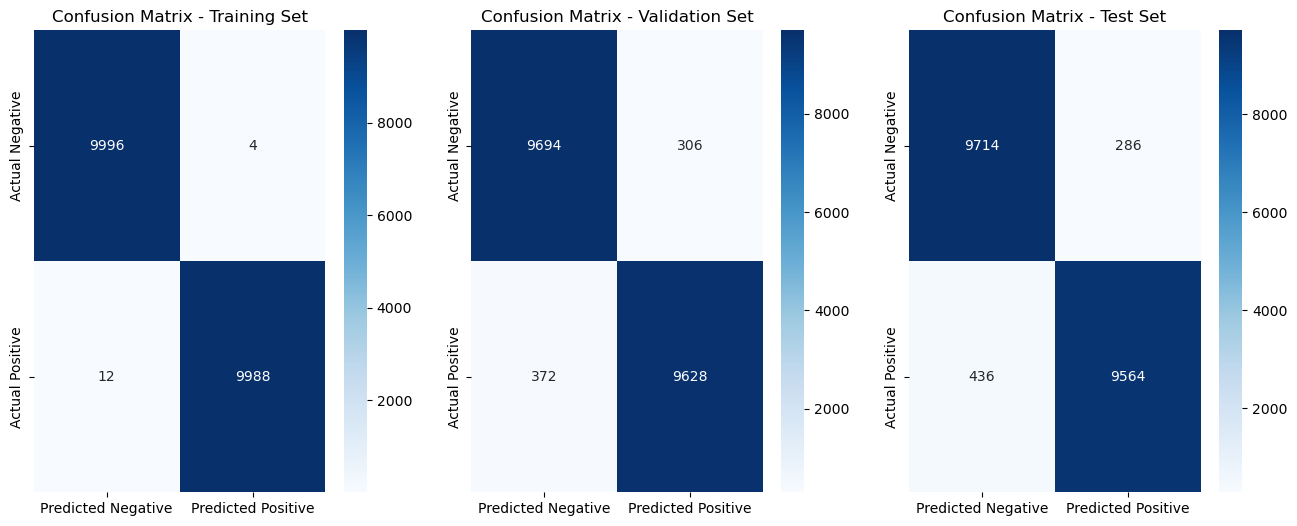

In [32]:
# predict values and confusion matrix
prediction2=prediction_confmatrix(model2)

decrease batch size 

In [33]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [34]:
# Load the MobileNetV2 model without the top (classification) layers
base_model3 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,586,177
Trainable params: 2,552,065
Non-trainable params: 34,112
_________________________________________________________________


In [35]:

# Compile the model
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=8, callbacks=[lr_scheduler,early_stopping])


Epoch 1/20
2500/2500 [==============================] - 834s 268ms/step - loss: 0.3811 - accuracy: 0.8275 - val_loss: 0.2775 - val_accuracy: 0.8880 - lr: 1.0000e-04
Epoch 2/20
2500/2500 [==============================] - 577s 231ms/step - loss: 0.2086 - accuracy: 0.9183 - val_loss: 0.1549 - val_accuracy: 0.9392 - lr: 9.5000e-05
Epoch 3/20
2500/2500 [==============================] - 571s 228ms/step - loss: 0.1301 - accuracy: 0.9516 - val_loss: 0.1510 - val_accuracy: 0.9448 - lr: 9.0250e-05
Epoch 4/20
2500/2500 [==============================] - 573s 229ms/step - loss: 0.0855 - accuracy: 0.9694 - val_loss: 0.2124 - val_accuracy: 0.9257 - lr: 8.5737e-05
Epoch 5/20
2500/2500 [==============================] - 587s 235ms/step - loss: 0.0687 - accuracy: 0.9757 - val_loss: 0.0965 - val_accuracy: 0.9668 - lr: 8.1451e-05
Epoch 6/20
2500/2500 [==============================] - 576s 230ms/step - loss: 0.0495 - accuracy: 0.9834 - val_loss: 0.2682 - val_accuracy: 0.9039 - lr: 7.7378e-05
Epoch 7/20

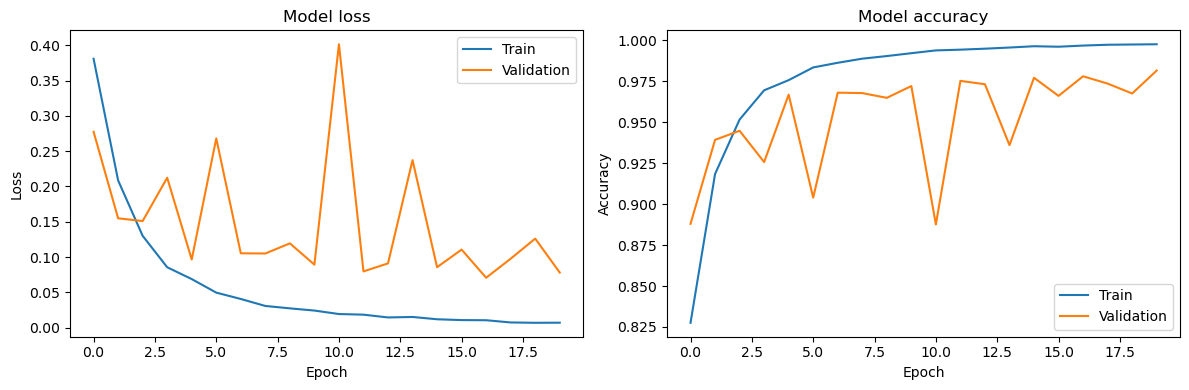

In [36]:
# Plot the learning curve
plot_learning_curve(history3)

In [37]:
# evaluate the model in test data
evaluation3=evaluate_test(model3)

625/625 [==============================] - 81s 126ms/step
Test Loss: 0.0800921767950058
Test Accuracy: 0.9813500046730042
Test Accuracy: 98.14%


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10000
           1       0.98      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



625/625 [==============================] - 89s 134ms/step
Confusion Matrix - Training Set:
[[9997    3]
 [   2 9998]]
Confusion Matrix - Validation Set:
[[9809  191]
 [ 179 9821]]
Confusion Matrix - Test Set:
[[9816  184]
 [ 189 9811]]


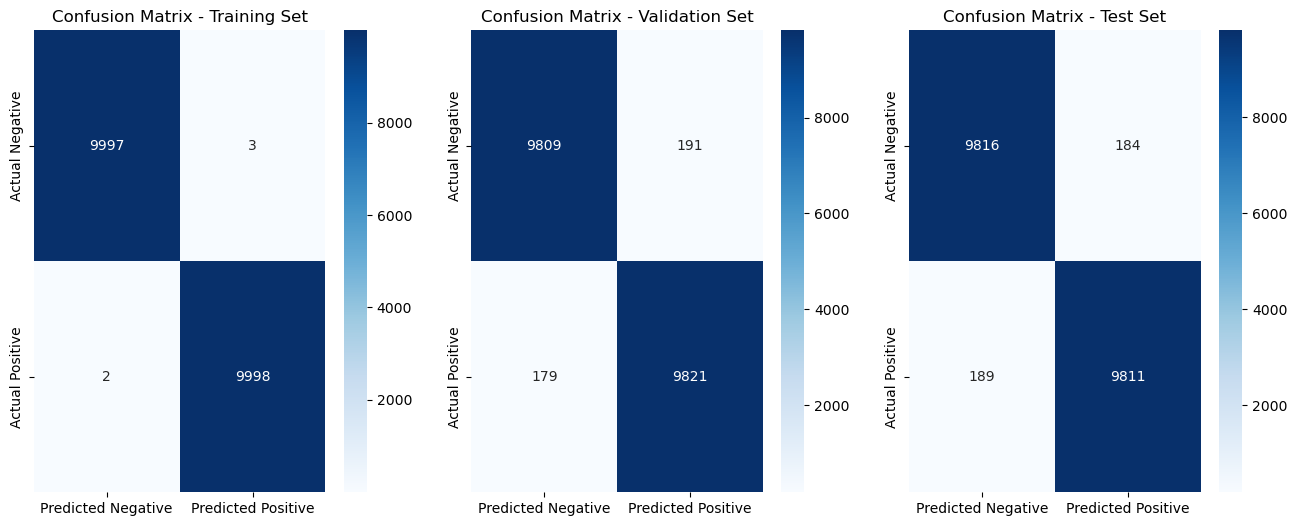

In [38]:
# predict values and confusion matrix
prediction3=prediction_confmatrix(model3)

In [54]:
# save whole model 
model3.save("MobileNetV2model3largescale")
model3.save("MobileNetV2model3withlargescale.h5")
#save only weights
model3.save_weights('MobileNetV2model3weightslargescale.h5')

INFO:tensorflow:Assets written to: MobileNetV2model3largescale\assets


INFO:tensorflow:Assets written to: MobileNetV2model3largescale\assets


In [55]:

# Compile the model
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history4 = model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=8, callbacks=[lr_scheduler,early_stopping])


Epoch 1/20
2500/2500 [==============================] - 691s 271ms/step - loss: 0.0306 - accuracy: 0.9905 - val_loss: 0.1622 - val_accuracy: 0.9502 - lr: 1.0000e-04
Epoch 2/20
2500/2500 [==============================] - 552s 221ms/step - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.1331 - val_accuracy: 0.9554 - lr: 9.5000e-05
Epoch 3/20
2500/2500 [==============================] - 548s 219ms/step - loss: 0.0192 - accuracy: 0.9937 - val_loss: 0.0876 - val_accuracy: 0.9729 - lr: 9.0250e-05
Epoch 4/20
2500/2500 [==============================] - 543s 217ms/step - loss: 0.0204 - accuracy: 0.9934 - val_loss: 0.1159 - val_accuracy: 0.9707 - lr: 8.5737e-05
Epoch 5/20
2500/2500 [==============================] - 542s 217ms/step - loss: 0.0165 - accuracy: 0.9946 - val_loss: 0.0992 - val_accuracy: 0.9649 - lr: 8.1451e-05
Epoch 6/20
2500/2500 [==============================] - 542s 217ms/step - loss: 0.0140 - accuracy: 0.9959 - val_loss: 0.0774 - val_accuracy: 0.9736 - lr: 7.7378e-05
Epoch 7/20

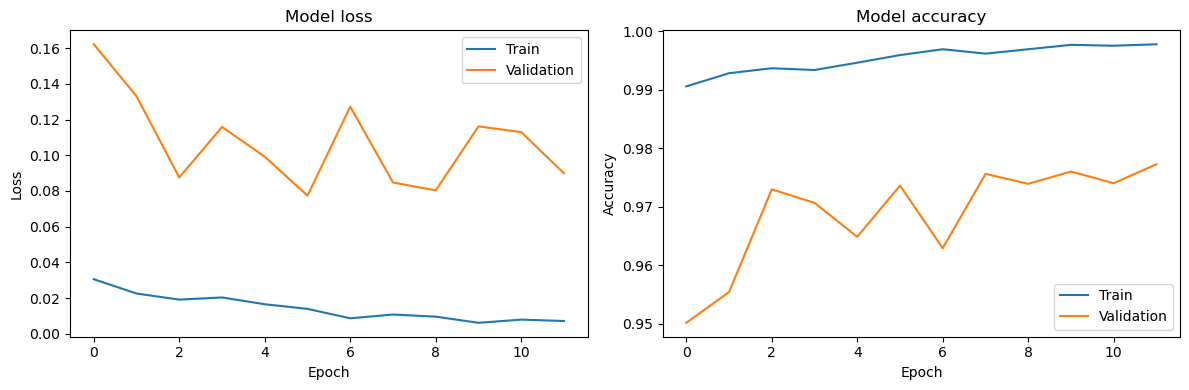

In [56]:
# Plot the learning curve
plot_learning_curve(history4)

In [57]:
# evaluate the model in test data
evaluation4=evaluate_test(model3)

625/625 [==============================] - 82s 125ms/step
Test Loss: 0.08651503175497055
Test Accuracy: 0.9717000126838684
Test Accuracy: 97.17%


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     10000
           1       0.97      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



625/625 [==============================] - 118s 154ms/step
Confusion Matrix - Training Set:
[[9979   21]
 [  44 9956]]
Confusion Matrix - Validation Set:
[[9776  224]
 [ 304 9696]]
Confusion Matrix - Test Set:
[[9748  252]
 [ 314 9686]]


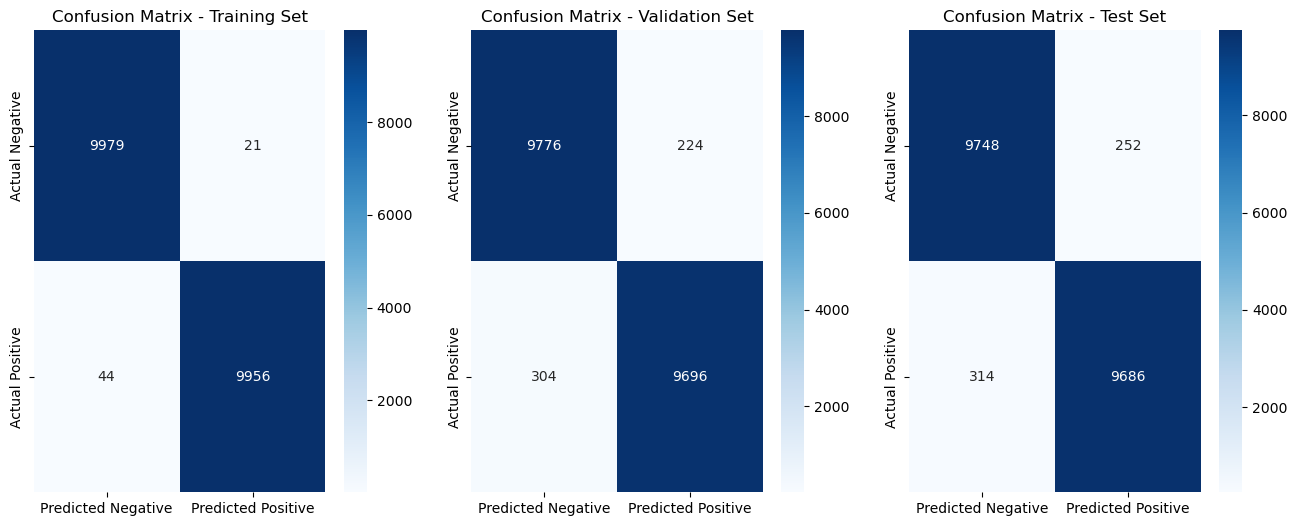

In [58]:
# predict values and confusion matrix
prediction4=prediction_confmatrix(model3)

comparison

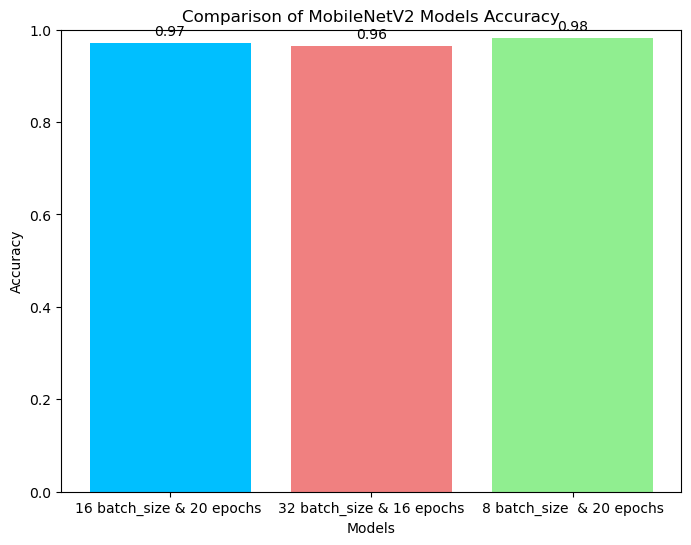

In [51]:

# Sample data for three models
models = ['16 batch_size & 20 epochs ', '32 batch_size & 16 epochs', '8 batch_size  & 20 epochs']
accuracy = [evaluation1[1],evaluation2[1],evaluation3[1]]

# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color=['deepskyblue','lightcoral', 'lightgreen' ])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of MobileNetV2 Models Accuracy')
plt.ylim(0, 1)  # Set y-axis range if needed


# Display the values on top of the bars
for i, value in enumerate(accuracy):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()

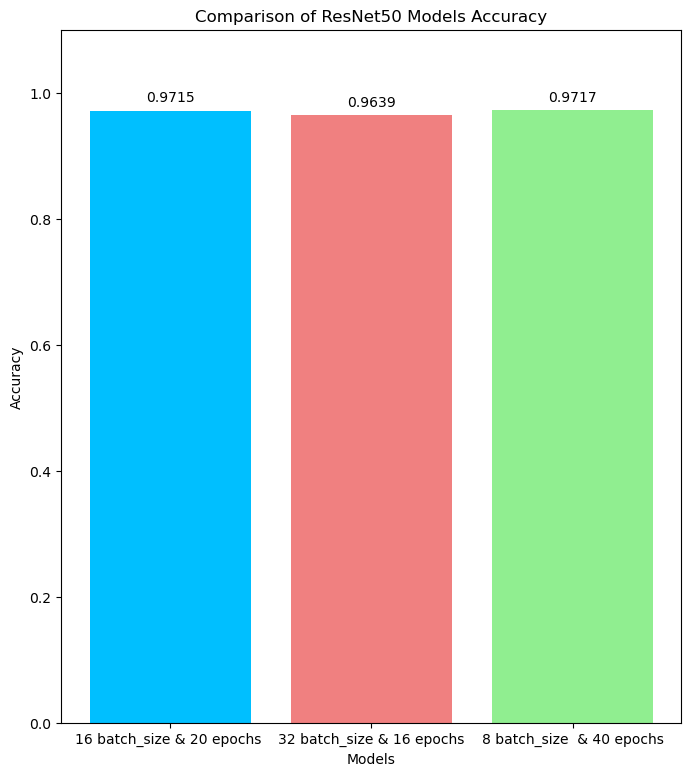

In [60]:
import matplotlib.pyplot as plt

# Sample data for three models
models = ['16 batch_size & 20 epochs ', '32 batch_size & 16 epochs', '8 batch_size  & 40 epochs']
accuracy = [evaluation1[1], evaluation2[1], evaluation4[1]]

# Bar chart
plt.figure(figsize=(8, 9))
bars = plt.bar(models, accuracy, color=['deepskyblue', 'lightcoral', 'lightgreen'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of ResNet50 Models Accuracy')
plt.ylim(0, 1.1)  # Set y-axis range slightly above 1 for better visualization

# Display the values on top of the bars without rounding
for bar, value in zip(bars, accuracy):
    plt.text(bar.get_x() + bar.get_width() / 2, min(value + 0.01, 1), f'{value:.4f}', ha='center', va='bottom')

# Show the plot
plt.show()
